# Prologue
On this research we want to predict smartphone movement on a surface based on the accelometer, gyroscope and magnometer sensors.

If we could find the general direction of this moving object, on a surface, based only on this two sensors, we could reduce the cost of manifacturing new sensors. In addition, we could develop new technology, encourging new ways to building models based on existing sensors.

# The Approach: Classification
0. preprocess the data
1. building a simple model
2. building a ML benchmark
3. building a siamese model
4. building a complex siamese model

## Imports of the notebook

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, Dense, concatenate, Concatenate, PReLU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre processing the data

In [2]:
def load_data():
    path = '../input/mousey-data'
    gens = None
    paths = os.listdir(path)
    for p in paths:
        p = path +'/'+ p
        for file in os.listdir(p):
            gen = pd.read_csv(p + '/' +file)
            if gens is None:
                gens = gen
            else:
                gens = pd.concat([gens, gen])
    return gens

gens = load_data()
gens

,Unnamed: 0,tag,accelometer_x,accelometer_y,accelometer_z,gyroscope_x,gyroscope_y,gyroscope_z,angle,diff,base
0,0,up,-0.126897,0.038308,9.632168,-0.001040,-0.004390,-0.182795,3.869976,0.089122,56.618526
1,1,up,-0.090982,0.052674,9.648928,-0.001651,-0.003169,-0.180963,3.869976,0.000000,56.618526
2,2,up,0.225062,0.079011,9.706390,-0.001040,-0.012332,-0.174854,3.869976,0.000000,56.618526
3,3,up,1.048692,5.224308,9.751882,0.002625,0.001718,-0.110713,3.869976,0.000000,56.618526
4,4,up,0.280130,3.131711,9.737515,-0.001040,-0.001947,-0.014807,3.869976,0.000000,56.618526
...,...,...,...,...,...,...,...,...,...,...,...
640,640,ned,-0.100560,0.045491,9.675264,-0.000292,0.002385,0.000444,0.856474,0.000000,56.895648
641,641,ned,-0.119714,0.031126,9.675264,-0.000903,0.002385,0.000444,0.856474,0.000000,56.895648
642,642,ned,-0.110137,0.028731,9.648928,-0.002125,0.007272,0.001055,0.856474,0.000000,56.895648
643,643,ned,-0.110137,0.002394,9.663293,-0.000903,0.003607,-0.000167,0.856474,0.000000,56.895648


We can see now that we have unnamed column that we do not need. Other columns are: tag we want to predict, acceleration and gyroscope data, angle data which is calculated from the magnometer data and diff column is the change of the current angle from the last measured angle.

In [3]:
gens.groupby(['tag'])['tag'].count()

tag
down         13878
downleft     14817
downright    15389
left         13513
ned          30706
right        12323
up           14028
upleft       15050
upright      14044
Name: tag, dtype: int64

We can see there is 9 classes for classification probelm, where almost 6000+ sampels for each class. 

Note: the Ned class mark the object did not move.

### Visiualization of the sensor data

We want to see how hard is the problem we are trying to solve. We will compare results between diffrent tags to see if we can understand something about the sensors and the categories

In [168]:
import matplotlib.pyplot as plt

def draw_compare_part_graph(ax, values, names, title):
    min_len = len(values[0])
    for val in values:
        if len(val) < min_len:
            min_len = len(val)
    for val in values:
        ax.plot(val[:min_len])
    ax.set_title(title)
    ax.legend(names, loc='upper left')

def get_values(data, tag, col):
    drop_cols = data.columns.tolist()
    drop_cols.remove(col)
    values = data[data['tag']==tag]
    values = values.drop(drop_cols, axis=1)
    return values.to_numpy()
    
def compare_categories(data, a, b):
    n = len(data.columns) - 1
    n_columns = 4
    n_rows = int(n / n_columns) + 1
    names = data.columns.tolist()
    names.remove('tag')

    fig = plt.figure(figsize=(30, 14))
    gs = fig.add_gridspec(n_rows, n_columns)

    for i in range(n_rows):
        for j in range(n_columns):
            index = i * n_columns + j
            if index < n:
                title = names[index]
                val_a = get_values(data, a, title)
                val_b = get_values(data, b, title)
                values = [val_a, val_b]
                ax = fig.add_subplot(gs[i, j])
                draw_compare_part_graph(ax, values, [a, b], title)

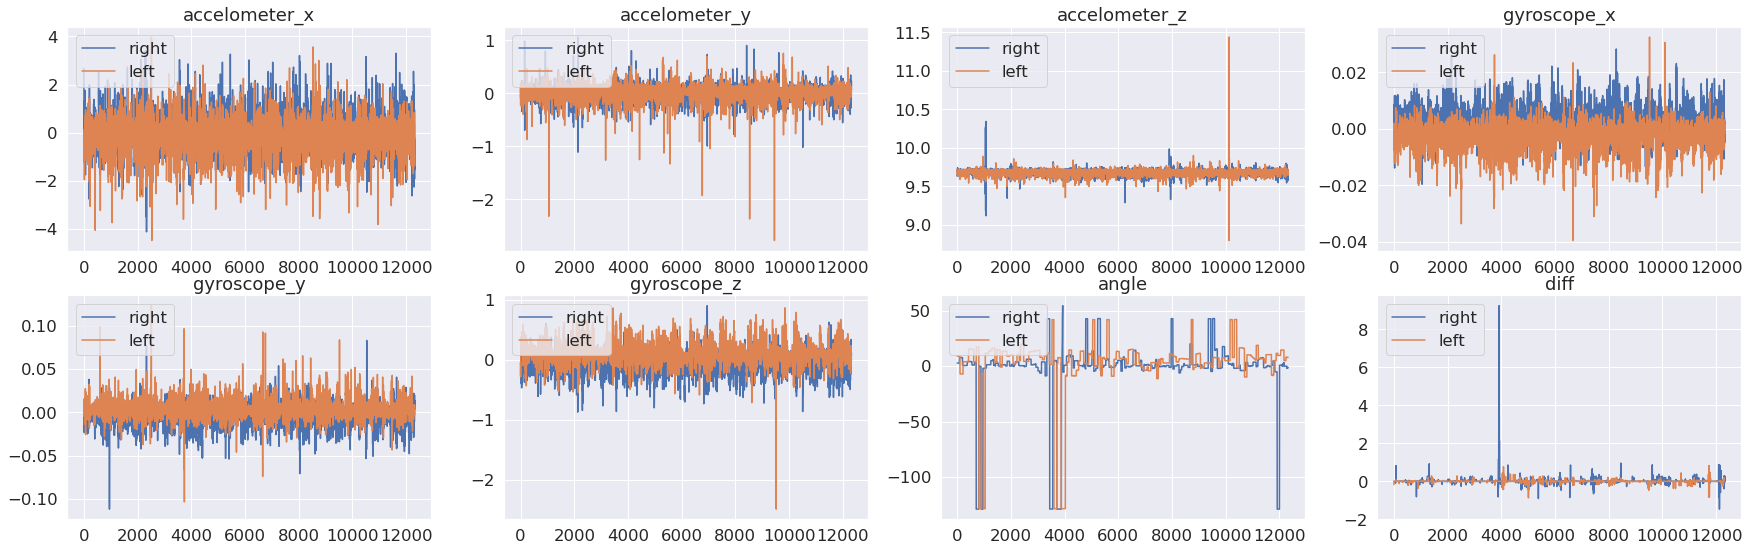

In [169]:
data = gens.drop(['base', 'Unnamed: 0'],axis=1)
compare_categories(data, 'right', 'left')

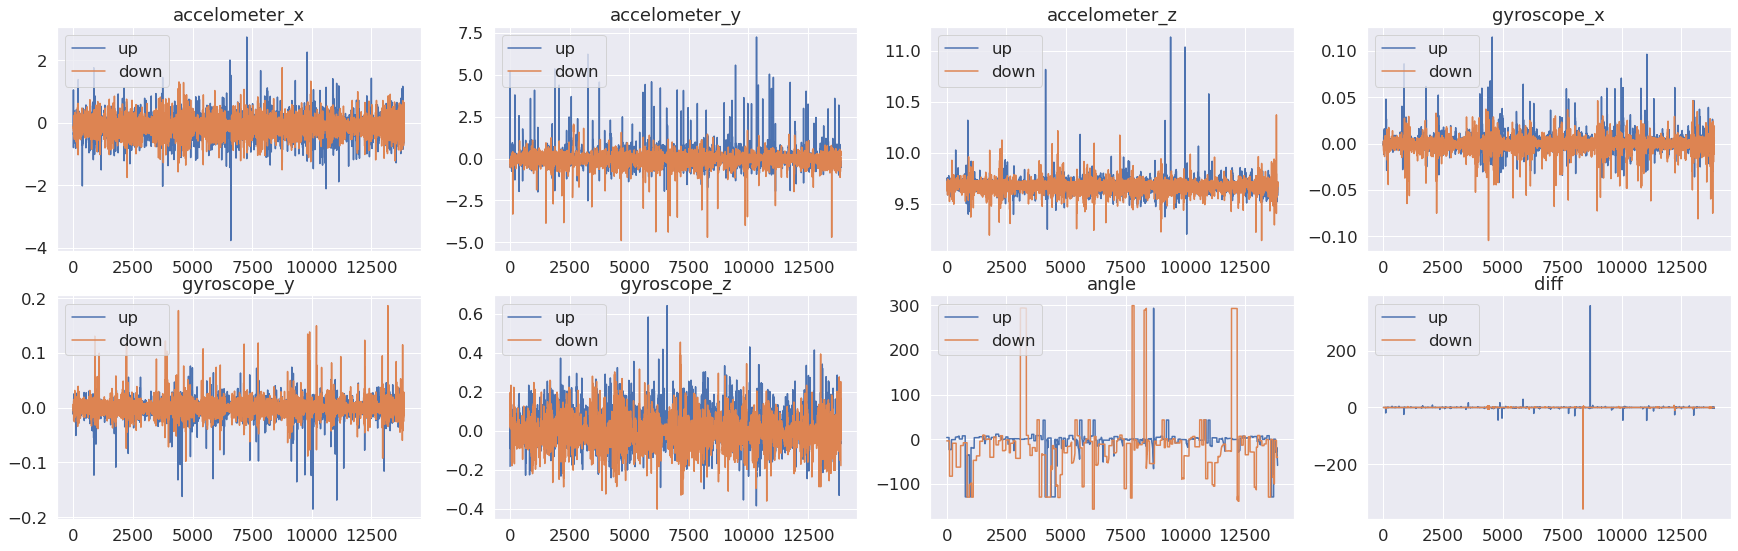

In [170]:
compare_categories(data, 'up', 'down')

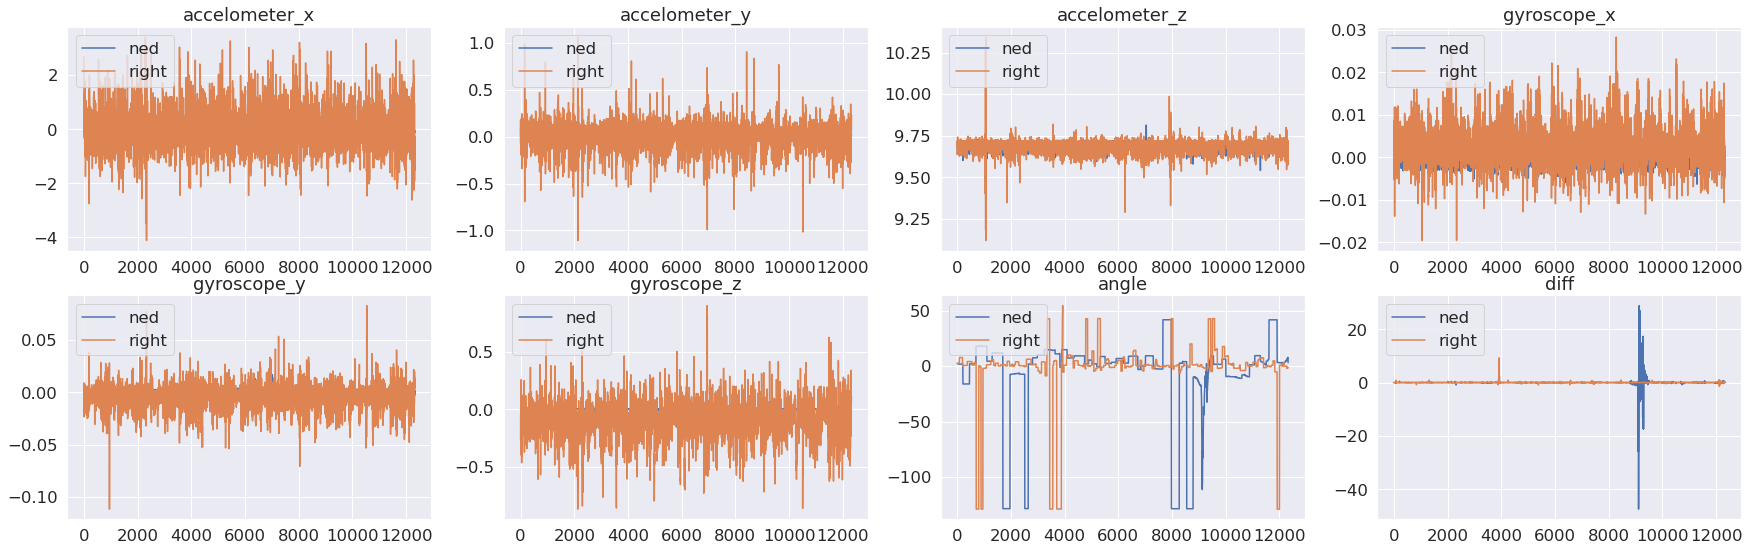

In [171]:
compare_categories(data, 'right', 'ned')

In [4]:
def create_X_y(gens):
    gens = gens.dropna()
    X = gens.drop(['tag', 'base', 'diff', 'Unnamed: 0'], axis=1)
    y = gens['tag']
    return X, y

X, y = create_X_y(gens)

In [5]:
def split_train_test(X, y, precentage = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=precentage)
    print('X train shape: ',X_train.shape, ' y train shape: ', y_train.shape)
    print('X test shape: ',X_test.shape, ' y test shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test

def y_to_categorical(y_train, y_test):
    dic = {x:i for i,x in enumerate(y_train.unique())}
    names = [x for x in y_train.unique()]
    len_train = len(y_train)
    y = np.concatenate([y_train.to_numpy(), y_test.to_numpy()])
    y = [dic[x] for x in y]
    y = to_categorical(y)
    y_train = y[0:len_train]
    y_test = [dic[x] for x in y_test]
    print('Changed to catigorical -> ','y train shape: ',len(y_train), '-> y test shape: ', len(y_test))
    return y_train, y_test, dic, names

X_train, X_test, y_train, y_test = split_train_test(X, y)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)

X train shape:  (114998, 7)  y train shape:  (114998,)
X test shape:  (28750, 7)  y test shape:  (28750,)
Changed to catigorical ->  y train shape:  114998 -> y test shape:  28750


Defining constants for the upcoming training models.

In [6]:
BATCH_SIZE = 64
EPOCKS = 50
CLASSES = 9
FEATURES = 7
FEATURES_SENSOR = 3
POINTS = 5

# Simple model

In [7]:
def create_callbacks(name, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    cheak_point = ModelCheckpoint(name)
    return [early_stopping, cheak_point]

def create_metrics():
    return ['accuracy']

def create_simple_model(size=FEATURES):
    inp = Input(shape=(None,size))
    x = Dense(32, activation='relu')(inp)
    x = Dense(64, activation='relu')(x)
    x = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='simple_model') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

simple_model = create_simple_model()
callbacks = create_callbacks('simple_model.h5')
history = simple_model.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.15, callbacks=callbacks)

Epoch 1/25
3055/3055 [==============================] - 5s 2ms/step - loss: 1.8017 - accuracy: 0.3668 - val_loss: 1.5696 - val_accuracy: 0.4573
Epoch 2/25
3055/3055 [==============================] - 5s 2ms/step - loss: 1.4383 - accuracy: 0.5174 - val_loss: 1.2729 - val_accuracy: 0.5626
Epoch 3/25
3055/3055 [==============================] - 5s 1ms/step - loss: 1.1932 - accuracy: 0.5884 - val_loss: 1.1354 - val_accuracy: 0.5992
Epoch 4/25
3055/3055 [==============================] - 4s 1ms/step - loss: 1.1164 - accuracy: 0.6101 - val_loss: 1.0787 - val_accuracy: 0.6184
Epoch 5/25
3055/3055 [==============================] - 5s 1ms/step - loss: 1.0823 - accuracy: 0.6173 - val_loss: 1.0804 - val_accuracy: 0.6179
Epoch 6/25
3055/3055 [==============================] - 5s 1ms/step - loss: 1.0604 - accuracy: 0.6245 - val_loss: 1.0289 - val_accuracy: 0.6361
Epoch 7/25
3055/3055 [==============================] - 5s 2ms/step - loss: 1.0405 - accuracy: 0.6302 - val_loss: 1.0214 - val_accuracy:

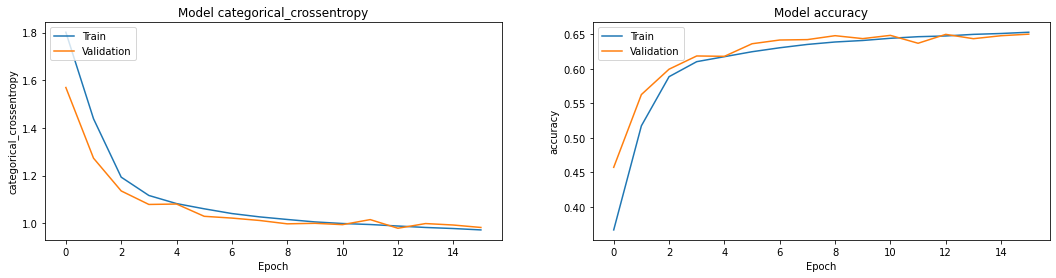

In [8]:
def quick_plot_loss(history, field, metric, ax):
    # Plot training & validation loss values
    ax.plot(history.history[field])
    ax.plot(history.history['val_'+field])
    ax.set_title('Model '+ metric)
    ax.set_ylabel(metric)
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')
                
    
def quick_plot_history(history):
    fig = plt.figure(figsize=(18, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('loss')
    quick_plot_loss(history, 'loss', 'categorical_crossentropy', ax)
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('accrucy')
    quick_plot_loss(history, 'accuracy', 'accuracy', ax)
    
quick_plot_history(history)

In [9]:
def test_results(model,X_test,y_test, LOAD=True):
    preds = model.predict(X_test)
    pred_cat = np.argmax(preds,axis=1) #takes the maximum prediction and compare it to the real prediction
    acc = accuracy_score(y_test,pred_cat)*100
    acc_saved = -1
    if LOAD:
        saved_model = load_model('./'+model.name+'.h5')
        preds = saved_model.predict(X_test)
        pred_cat = np.argmax(preds,axis=1) #takes the maximum prediction and compare it to the real prediction
        acc_saved = accuracy_score(y_test,pred_cat)*100
    if acc >= acc_saved:
        if LOAD:
            model.save('./'+model.name+'.h5')
        print('NEW: model accuracy on test set is: {0:.2f}%'.format(acc))
    else:
        print('model accuracy on test set is: {0:.2f}%'.format(acc_saved))        

test_results(simple_model, X_test, y_test)

NEW: model accuracy on test set is: 64.75%


# ML benchmark

In [10]:
forest = RandomForestRegressor(n_estimators = 100, max_depth = 8)
forest.fit(X_train,y_train)
test_results(forest, X_test, y_test, LOAD=False)

NEW: model accuracy on test set is: 62.92%


# Siamese model - sensor based
On this siamese model there are 3 input channels - accelometer (3) , gyroscope(3) , angle(2)

![image.png](attachment:image.png)

In [11]:
def split_input_channels(X):
    acc = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z','angle'], axis=1)
    gyro = X.drop(['accelometer_x','accelometer_y','accelometer_z','angle'], axis=1)
    angle = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z','accelometer_x','accelometer_y','accelometer_z'], axis=1)
    return acc, gyro, angle


def create_siamese_model(acc_size, gyro_size, angle_size):
    acc_inp = Input(shape=acc_size)
    acc = Dense(32, activation='relu')(acc_inp)
    acc = Dense(64, activation='relu')(acc)
    
    gyro_inp = Input(shape=gyro_size)
    gyro = Dense(32, activation='relu')(gyro_inp)
    gyro = Dense(64, activation='relu')(gyro)
    
    angle_inp = Input(shape=angle_size)
    angle = Dense(32, activation='relu')(angle_inp)
    angle = Dense(64, activation='relu')(angle)
    
    x = concatenate([acc, gyro, angle])
    x = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=[acc_inp, gyro_inp, angle_inp], outputs=x, name='siamese_model') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

siamese_model = create_siamese_model(FEATURES_SENSOR, FEATURES_SENSOR, 1)
acc, gyro, angle = split_input_channels(X_train)
callbacks = create_callbacks('siamese_model.h5')
history = siamese_model.fit([acc,gyro,angle], y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/25
2875/2875 [==============================] - 6s 2ms/step - loss: 1.3316 - accuracy: 0.5417 - val_loss: 1.1221 - val_accuracy: 0.6122
Epoch 2/25
2875/2875 [==============================] - 6s 2ms/step - loss: 1.0729 - accuracy: 0.6204 - val_loss: 1.0488 - val_accuracy: 0.6299
Epoch 3/25
2875/2875 [==============================] - 5s 2ms/step - loss: 1.0344 - accuracy: 0.6329 - val_loss: 1.0273 - val_accuracy: 0.6359
Epoch 4/25
2875/2875 [==============================] - 6s 2ms/step - loss: 1.0112 - accuracy: 0.6393 - val_loss: 1.0071 - val_accuracy: 0.6430
Epoch 5/25
2875/2875 [==============================] - 6s 2ms/step - loss: 0.9931 - accuracy: 0.6458 - val_loss: 0.9959 - val_accuracy: 0.6500
Epoch 6/25
2875/2875 [==============================] - 6s 2ms/step - loss: 0.9802 - accuracy: 0.6498 - val_loss: 0.9843 - val_accuracy: 0.6561
Epoch 7/25
2875/2875 [==============================] - 6s 2ms/step - loss: 0.9710 - accuracy: 0.6539 - val_loss: 0.9858 - val_accuracy:

NEW: model accuracy on test set is: 66.70%


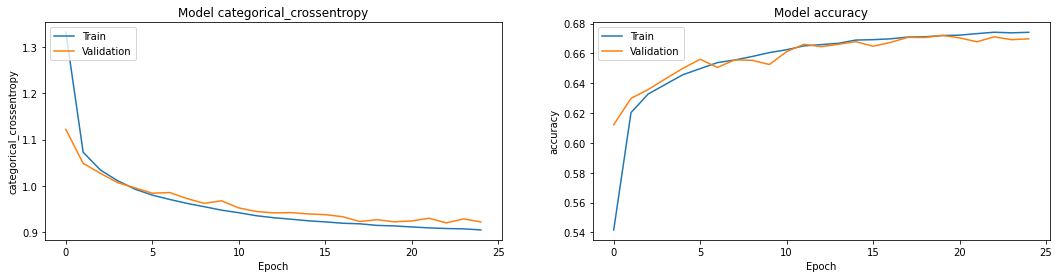

In [12]:
quick_plot_history(history)
acc, gyro, angle = split_input_channels(X_test)
test_results(siamese_model, [acc, gyro, angle], y_test)

# Complex Siamese Model
On this siamese model there are N input channels - the current data sensors, the data sensors 1 before, the data sensors 2 before, etc.

This Siamese model will try to take:
1. a window size 2 and use this window as the model input.
2. a window size 5 and use this window as the model input.
3. a window size 9 and use this window as the model input.

![image.png](attachment:image.png)

In [13]:
def split_train_test_by_sliding_window(X,y, N=2):
    grouped = gens.groupby('tag')
    X_tmp = None
    X_original = None
    y_original = None
    start = N
    end = None
    for g in grouped:
        X, y = create_X_y(g[1])
        end = len(X)
        tmp_dic = {}
        if X_original is None:
            X_original = X.iloc[start:]
            y_original = y.iloc[start:]
        else:
            X_original = pd.concat([X_original,X.iloc[start:]])
            y_original = pd.concat([y_original, y.iloc[start:]])
        for col in X.columns:
            for i in range(1,N,1):
                name = 'prev_'+str(i)+'_'+col

                tmp_dic[name] = X[col].iloc[start-i: end-i].values
        if X_tmp is None:
            X_tmp = pd.DataFrame.from_dict(tmp_dic)
        else:
            X_tmp = pd.concat([X_tmp, pd.DataFrame.from_dict(tmp_dic)])
    X_original = X_original.reset_index()
    X_tmp = X_tmp.reset_index()
    X_tmp = pd.concat([X_tmp, X_original], axis=1)
    X_tmp = X_tmp.drop(['index'], axis=1)
    print('X devide: ',X_tmp.shape, ' y devide: ', y_original.shape)
    X_train, X_test, y_train, y_test = split_train_test(X_tmp, y_original)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)
X_train.head()

X devide:  (143703, 35)  y devide:  (143703,)
X train shape:  (114962, 35)  y train shape:  (114962,)
X test shape:  (28741, 35)  y test shape:  (28741,)
Changed to catigorical ->  y train shape:  114962 -> y test shape:  28741


,prev_1_accelometer_x,prev_2_accelometer_x,prev_3_accelometer_x,prev_4_accelometer_x,prev_1_accelometer_y,prev_2_accelometer_y,prev_3_accelometer_y,prev_4_accelometer_y,prev_1_accelometer_z,prev_2_accelometer_z,...,prev_2_angle,prev_3_angle,prev_4_angle,accelometer_x,accelometer_y,accelometer_z,gyroscope_x,gyroscope_y,gyroscope_z,angle
66980,-0.095771,-0.090982,-0.088588,-0.095771,0.021548,0.016760,0.016760,0.031126,9.632168,9.648928,...,4.316026,4.316026,4.316026,-0.081405,0.031126,9.651321,0.000181,0.000630,-0.000922,4.316026
135595,-0.064645,-0.095771,-0.136474,-0.146051,0.038308,0.033520,0.028731,0.016760,9.706390,9.692024,...,0.529517,0.529517,0.529517,-0.105348,0.016760,9.675264,0.001784,-0.053373,0.568922,0.529517
106044,-0.026337,0.050280,0.069434,-0.193936,0.153234,0.205908,0.117319,0.191542,9.687236,9.653716,...,-2.343583,-2.280553,-2.470205,-0.004789,0.289707,9.636956,-0.000048,-0.010612,0.099167,-2.152953
92348,0.179571,0.275342,0.852362,0.928979,-0.117319,-0.112531,-0.119714,0.083800,9.718362,9.718362,...,9.069201,9.069201,9.069201,0.234639,-0.043097,9.713573,-0.000429,-0.001202,-0.044905,9.069201
104333,-0.122108,-0.136474,-0.122108,-0.107742,0.014366,0.011971,0.021548,0.007183,9.718362,9.715967,...,8.260859,8.260859,8.260859,-0.131685,0.028731,9.718362,0.002216,-0.013693,0.045828,8.260859


In [14]:
def sp_acc_txt(prev=None):
    if prev is None:
        return ['accelometer_x','accelometer_y','accelometer_z']
    name = 'prev_'+str(prev)+'_'
    return [name+'accelometer_x',name+'accelometer_y',name+'accelometer_z']

def split_acc(points,index=None):
    l = []
    if index is None or index != 0:
        l = sp_acc_txt()
    for i in range(1,points):
        if index is None or i != index:
            l += sp_acc_txt(prev=i)
    return l

def sp_gyro_txt(prev=None):
    if prev is None:
        return ['gyroscope_x','gyroscope_y','gyroscope_z']
    name = 'prev_'+str(prev)+'_'
    return [name+'gyroscope_x',name+'gyroscope_y',name+'gyroscope_z']

def split_gyro(points,index=None):
    l = []
    if index is None or index != 0:
        l = sp_gyro_txt()
    for i in range(1,points):
        if index is None or i != index:
            l += sp_gyro_txt(prev=i)
    return l

def sp_angle_txt(prev=None):
    if prev is None:
        return ['angle']
    name = 'prev_'+str(prev)+'_'
    return [name+'angle']

def split_angle(points,index=None):
    l = []
    if index is None or index != 0:
        l = sp_angle_txt()
    for i in range(1,points):
        if index is None or i != index:
            l += sp_angle_txt(prev=i)
    return l 

def split_channels(X, p=5):
    t = ()
    l = None
    acc = None
    gyto = None
    angle = None
    for i in range(p):
        l = split_acc(p, index=i) + split_gyro(p) + split_angle(p)
        acc = X.drop(l, axis=1)
        l = split_acc(p) + split_gyro(p, index=i) + split_angle(p)
        gyro = X.drop(l, axis=1)
        l = split_acc(p) + split_gyro(p) + split_angle(p, index=i)
        angle = X.drop(l, axis=1)
        t += (acc , gyro, angle) 
    return t

In [15]:
def dense_depth_block(inp, N=32, extend_N=4, deapth=5):
    if deapth==0:
        return inp
    x = None 
    prev_x = None
    xs = []
    for i in range(0, deapth):
        if x is None:
            x = Dense(N)(inp)
            x = PReLU()(x)
        else:
            prev_x = x
            x = Dense(N + i*extend_N)(prev_x)
            x = PReLU()(x)
        xs.append(x)
    if len(xs) != 1:
        x = concatenate(xs)
    return x

def create_chanel(size=FEATURES_SENSOR, deapth=5, N=32,extend_N=16):
    inp = Input(shape=size)
    x = dense_depth_block(inp, deapth=deapth, N=N, extend_N=extend_N)
    return inp, x

In [48]:
def create_complex_siamese_model(p=POINTS):
    inputs= []
    cs = []
    for i in range(p):
        inp_acc, c_acc = create_chanel(size=3,deapth=2,N=16)
        inputs.append(inp_acc)
        cs.append(c_acc)
        inp_gyro, c_gyro = create_chanel(size=3,deapth=2,N=16)
        inputs.append(inp_gyro)
        cs.append(c_gyro)
        inp_angle, c_angle = create_chanel(size=1,deapth=2,N=16)
        inputs.append(inp_angle)
        cs.append(c_angle)
        
#         f1 = concatenate([c_acc * c_acc, c_gyro * c_gyro, c_angle * c_angle])
#         f1 = Dense(16, activation='relu')(f1)
#         cs.append(f1)
        
        
        f2 = concatenate([tf.math.exp(c_acc), tf.math.exp(c_gyro)])
        f2 = Dense(16, activation='relu')(f2)
        cs.append(f2)
        
    x = concatenate(cs)
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(128)(x)
    x = PReLU()(x)
    x = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x, name='complex_siamese_'+str(p)+'_model') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model, 'complex_siamese_'+str(p)+'_model'

### 2 Points

In [17]:
POINTS = 2
X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)
complex_siamese_model, name = create_complex_siamese_model(p=POINTS)
callbacks = create_callbacks(name+'.h5')
history = complex_siamese_model.fit(split_channels(X_train, p=POINTS), y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

X devide:  (143730, 14)  y devide:  (143730,)
X train shape:  (114984, 14)  y train shape:  (114984,)
X test shape:  (28746, 14)  y test shape:  (28746,)
Changed to catigorical ->  y train shape:  114984 -> y test shape:  28746
Epoch 1/25
2875/2875 [==============================] - 13s 5ms/step - loss: 1.1979 - accuracy: 0.5795 - val_loss: 0.9897 - val_accuracy: 0.6472
Epoch 2/25
2875/2875 [==============================] - 12s 4ms/step - loss: 0.9688 - accuracy: 0.6518 - val_loss: 0.9356 - val_accuracy: 0.6655
Epoch 3/25
2875/2875 [==============================] - 12s 4ms/step - loss: 0.9256 - accuracy: 0.6659 - val_loss: 0.8987 - val_accuracy: 0.6747
Epoch 4/25
2875/2875 [==============================] - 13s 5ms/step - loss: 0.8964 - accuracy: 0.6753 - val_loss: 0.8702 - val_accuracy: 0.6859
Epoch 5/25
2875/2875 [==============================] - 12s 4ms/step - loss: 0.8725 - accuracy: 0.6831 - val_loss: 0.8564 - val_accuracy: 0.6931
Epoch 6/25
2875/2875 [=========================

NEW: model accuracy on test set is: 72.94%


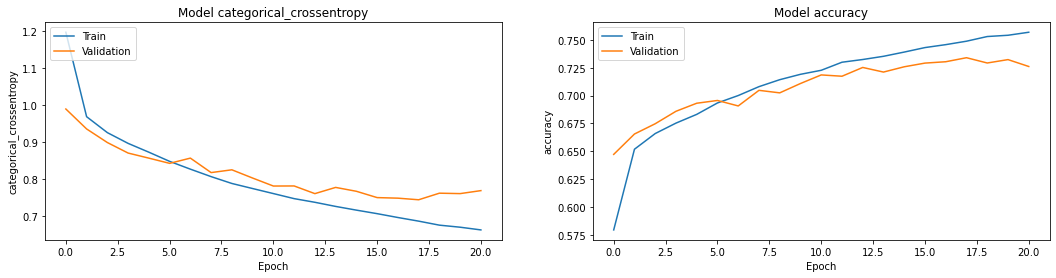

In [18]:
quick_plot_history(history)
test_results(complex_siamese_model, split_channels(X_test, p=POINTS), y_test)

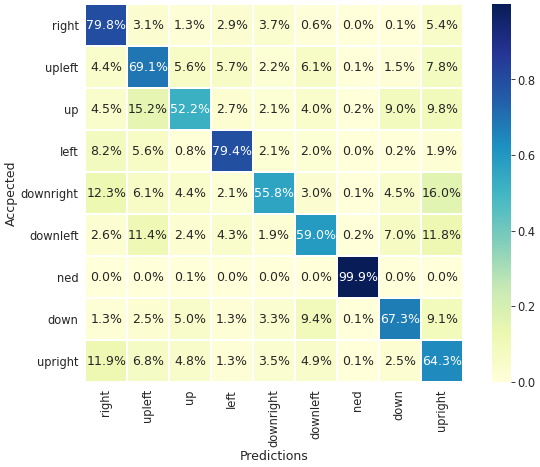

In [19]:
def plot_confusion_matrix(y_test, preds, y_names):
    con = confusion_matrix(y_test, preds)
    con = con / np.sum(con, axis=1)
    plt.figure(figsize=(15,10), dpi=50)
    sns.set(font_scale=1.5)
    sns.heatmap(con, xticklabels=y_names, yticklabels=y_names, linewidths=2, annot=True, fmt = '.1%',cmap="YlGnBu",square=True)
    plt.xlabel('Predictions')
    plt.ylabel('Accpected')
    
preds = complex_siamese_model.predict(split_channels(X_test, p=POINTS))
preds = np.argmax(preds,axis=1)
plot_confusion_matrix(y_test, preds, y_names)

We can see that the model is not accurate and an "up" movement is predicted as "down".

### 5 Points

In [49]:
POINTS = 5
X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)
print(y_dic)
complex_siamese_model, name = create_complex_siamese_model(p=POINTS)
callbacks = create_callbacks(name+'.h5')
history = complex_siamese_model.fit(split_channels(X_train, p=POINTS), y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

X devide:  (143703, 35)  y devide:  (143703,)
X train shape:  (114962, 35)  y train shape:  (114962,)
X test shape:  (28741, 35)  y test shape:  (28741,)
Changed to catigorical ->  y train shape:  114962 -> y test shape:  28741
{'downleft': 0, 'left': 1, 'upleft': 2, 'down': 3, 'right': 4, 'up': 5, 'ned': 6, 'upright': 7, 'downright': 8}
Epoch 1/25
2875/2875 [==============================] - 23s 8ms/step - loss: 1.1394 - accuracy: 0.6178 - val_loss: 0.9844 - val_accuracy: 0.6606
Epoch 2/25
2875/2875 [==============================] - 22s 8ms/step - loss: 0.8464 - accuracy: 0.7004 - val_loss: 0.8275 - val_accuracy: 0.6990
Epoch 3/25
2322/2875 [=======================>......] - ETA: 3s - loss: 0.7799 - accuracy: 0.7207

KeyboardInterrupt: 

NEW: model accuracy on test set is: 80.57%


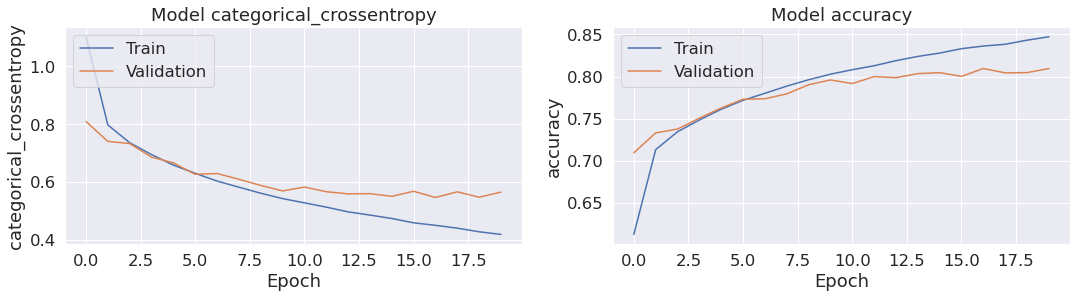

In [21]:
quick_plot_history(history)
test_results(complex_siamese_model, split_channels(X_test, p=POINTS), y_test)

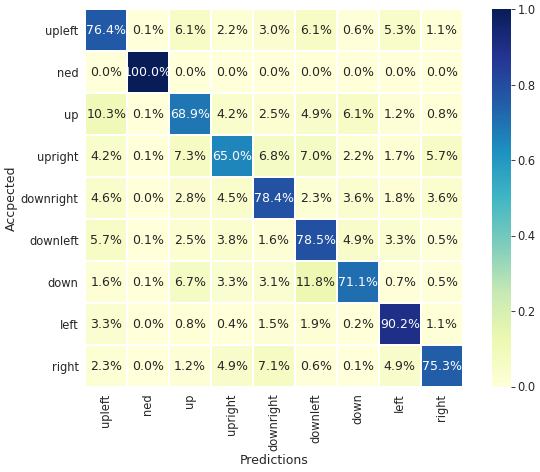

In [22]:
preds = complex_siamese_model.predict(split_channels(X_test, p=POINTS))
preds = np.argmax(preds,axis=1)
plot_confusion_matrix(y_test, preds, y_names)

We can see that the model is not accurate and an "down" movement is predicted as "up".

### 9 Points

In [23]:
POINTS = 9
X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)
print(y_dic)
complex_siamese_model, name = create_complex_siamese_model(p=POINTS)
callbacks = create_callbacks(name+'.h5')
history = complex_siamese_model.fit(split_channels(X_train, p=POINTS), y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

X devide:  (143667, 63)  y devide:  (143667,)
X train shape:  (114933, 63)  y train shape:  (114933,)
X test shape:  (28734, 63)  y test shape:  (28734,)
Changed to catigorical ->  y train shape:  114933 -> y test shape:  28734
{'ned': 0, 'upleft': 1, 'right': 2, 'left': 3, 'downright': 4, 'upright': 5, 'downleft': 6, 'down': 7, 'up': 8}
Epoch 1/25
2874/2874 [==============================] - 31s 11ms/step - loss: 1.0365 - accuracy: 0.6399 - val_loss: 0.7652 - val_accuracy: 0.7288
Epoch 2/25
2874/2874 [==============================] - 30s 10ms/step - loss: 0.6698 - accuracy: 0.7590 - val_loss: 0.6278 - val_accuracy: 0.7710
Epoch 3/25
2874/2874 [==============================] - 29s 10ms/step - loss: 0.5841 - accuracy: 0.7880 - val_loss: 0.5744 - val_accuracy: 0.7922
Epoch 4/25
2874/2874 [==============================] - 30s 10ms/step - loss: 0.5385 - accuracy: 0.8047 - val_loss: 0.5374 - val_accuracy: 0.8028
Epoch 5/25
2874/2874 [==============================] - 29s 10ms/step - loss

NEW: model accuracy on test set is: 86.76%


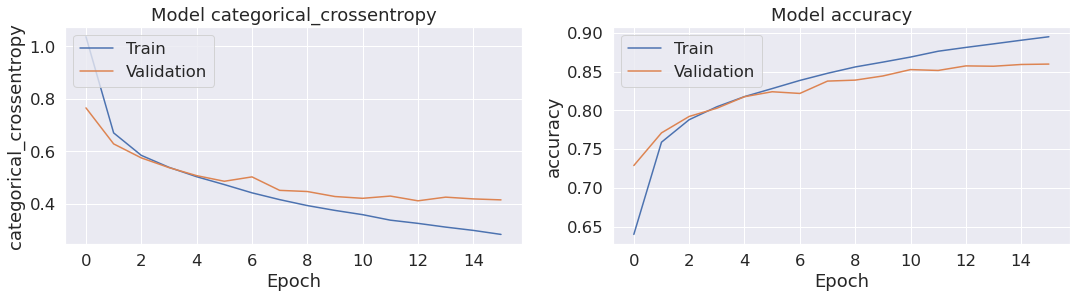

In [24]:
quick_plot_history(history)
test_results(complex_siamese_model, split_channels(X_test, p=POINTS), y_test)

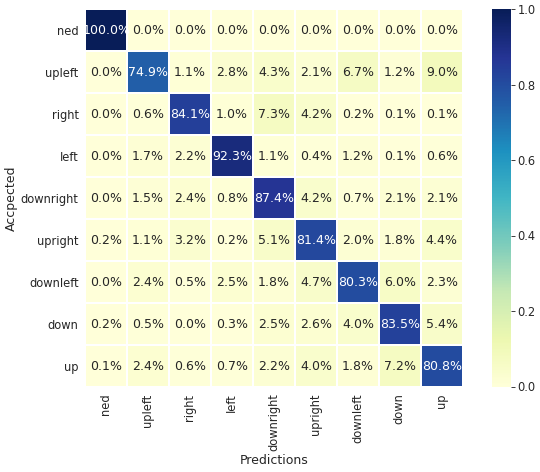

In [25]:
preds = complex_siamese_model.predict(split_channels(X_test, p=POINTS))
preds = np.argmax(preds,axis=1)
plot_confusion_matrix(y_test, preds, y_names)

## 11 points

In [26]:
POINTS = 11
X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)
print(y_dic)
complex_siamese_model, name = create_complex_siamese_model(p=POINTS)
callbacks = create_callbacks(name+'.h5')
history = complex_siamese_model.fit(split_channels(X_train, p=POINTS), y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

X devide:  (143649, 77)  y devide:  (143649,)
X train shape:  (114919, 77)  y train shape:  (114919,)
X test shape:  (28730, 77)  y test shape:  (28730,)
Changed to catigorical ->  y train shape:  114919 -> y test shape:  28730
{'right': 0, 'left': 1, 'down': 2, 'downleft': 3, 'upleft': 4, 'ned': 5, 'up': 6, 'downright': 7, 'upright': 8}
Epoch 1/25
2873/2873 [==============================] - 37s 13ms/step - loss: 0.9893 - accuracy: 0.6568 - val_loss: 0.7092 - val_accuracy: 0.7523
Epoch 2/25
2873/2873 [==============================] - 36s 13ms/step - loss: 0.6082 - accuracy: 0.7806 - val_loss: 0.5740 - val_accuracy: 0.7905
Epoch 3/25
2873/2873 [==============================] - 36s 13ms/step - loss: 0.5218 - accuracy: 0.8113 - val_loss: 0.5298 - val_accuracy: 0.8073
Epoch 4/25
2873/2873 [==============================] - 35s 12ms/step - loss: 0.4706 - accuracy: 0.8299 - val_loss: 0.4824 - val_accuracy: 0.8240
Epoch 5/25
2873/2873 [==============================] - 34s 12ms/step - loss

NEW: model accuracy on test set is: 89.18%


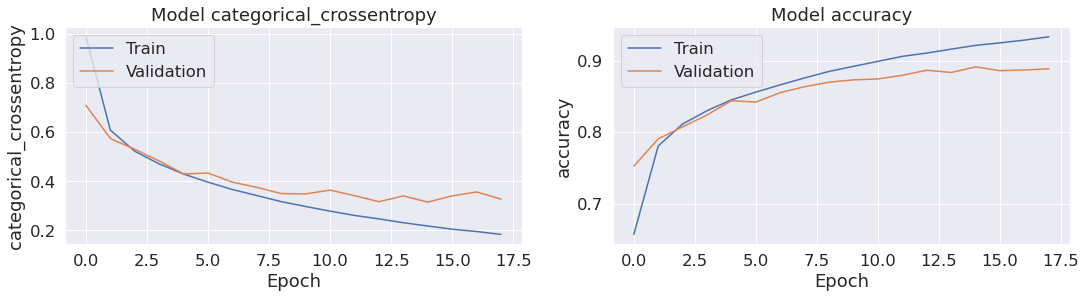

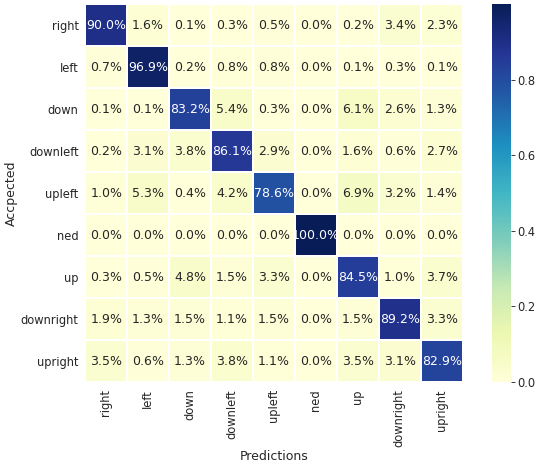

In [27]:
quick_plot_history(history)
test_results(complex_siamese_model, split_channels(X_test, p=POINTS), y_test)
preds = complex_siamese_model.predict(split_channels(X_test, p=POINTS))
preds = np.argmax(preds,axis=1)
plot_confusion_matrix(y_test, preds, y_names)

# Summary
We have learned how to solve an unknown problem and saw couple of new ways of solving classification problems which are sensor based. Those resaults are at the highest accuracy I could reach, during my attemps to predict the smartphone movment, using acceleration, gyroscope and magnometer sensors. In addition, we have learned how to build Siamese Model based on sensors. 

We found out that the greater the sliding window, the greater is the prediction accuracy.
![image.png](attachment:image.png)